# CheXNet Implementation for Pneumonia Detection

In [6]:
#Pre-requisites for CheXNet

In [7]:
# Install pydicom for reading .DICOM files
#!pip install pydicom

In [60]:
# Import all required libraries
import pandas as pd
import numpy as np
import pydicom
import pylab
from skimage.transform import resize
import pathlib
import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [9]:
# Set the path for training images
TRAIN_IMAGES ='E:/Machine Learning/Great Learning/Projects/GL Capstone Project/GL Capstone Project/Dataset/rsna-pneumonia-detection-challenge/stage_2_train_images/'
Dataset = 'E:/Machine Learning/Great Learning/Projects/GL Capstone Project/GL Capstone Project/Dataset/rsna-pneumonia-detection-challenge'
weights = 'E:/Machine Learning/Great Learning/Projects/GL Capstone Project/GL Capstone Project/Code Base/ChexNet/'

In [10]:
# Read the training CSV File and remove duplicates on Patient Id
filepath = (Dataset+'/stage_2_train_labels.csv')
Images_df = pd.read_csv(filepath)
Images_model_df = Images_df[['patientId','Target']]
Images_model_df=Images_model_df.drop_duplicates(subset='patientId')

In [11]:
# Sample the training images for initial experimentation
Images_sample_df = Images_model_df.sample(frac=1.0,random_state=42)

In [12]:
# Get the count
Images_sample_df['Target'].value_counts()

0    20672
1     6012
Name: Target, dtype: int64

In [61]:
def train_test_dict(Images_sample_df,test_size,random_state=42): 
   # Split into train and test validation datasets
    train_df, test_df = train_test_split(Images_sample_df, test_size=0.02, random_state=42, stratify=Images_sample_df[['Target']])
   # Convert to dictionary with patient-id as key and target as value
    train_dict=train_df.set_index('patientId')['Target'].to_dict()
    test_dict=test_df.set_index('patientId')['Target'].to_dict()

In [16]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
#your_module = drive.CreateFile({'id':'185RGsTqpjcdKK2afnDs5LVxIZW6GTQZj'})
#your_module.GetContentFile('generator.py')

In [17]:
# Define Custom Generator Class to be used in Model Generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path,batch_size=128, dim=(224,224), n_channels=3,
                 n_classes=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path = path
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dcm_file_sample = (self.path +"/"+ ID +".dcm")
            dcm_data_sample = pydicom.filereader.dcmread(dcm_file_sample)
            image = dcm_data_sample.pixel_array
            image_array = np.stack([image] * 3, axis=2)
            image_array = image_array / 255.
            image_array = resize(image_array, (224, 224), mode= 'constant', anti_aliasing=True)
            X[i,] = image_array

            # Store class
            y[i] = self.labels[ID]

        return X,y

In [18]:
from keras.models import load_model

In [19]:
# Define the DenseNet model pre-loaded with imagenet weights with last layer set as false
input_shape = (224, 224, 3)
num_of_class=1
img_in = Input(input_shape)              
model = DenseNet121(include_top= False , 
                weights=weights+'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',    
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

# The pre-trained model has classification output for 14 categories and hence Dense layer is defined with layer 14
x = model.output  
predictions = Dense(14, activation="sigmoid", name="predictions")(x)    
model = Model(inputs=img_in, outputs=predictions)

In [20]:
# Load pre-trained weights on similar dataset
model.load_weights(weights+"brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [21]:
# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [22]:
# Remove the last dense layer of 14 classes and print the summary
model.layers.pop()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [23]:
# Add a new dense layer of 1 class and chain the previous layer output to new model
new_layer = Dense(1, activation="sigmoid", name="my_predictions")    
inp = model.input
out = new_layer(model.layers[-1].output)
model2 = Model(inp, out)

In [24]:
#Print new model summary
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [25]:
# Create Train and Test generator
train_generator = DataGenerator(list(train_dict.keys()), train_dict,path=TRAIN_IMAGES,batch_size=32)
validation_generator = DataGenerator(list(test_dict.keys()), test_dict,path=TRAIN_IMAGES,batch_size=1)

In [26]:
#Define Custom Metrics Functions to be used in Keras Training
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
#Set Early stopping parameter and Reduce Learning rate on Plateau
callbacks_list = [EarlyStopping(monitor='val_loss',patience=5,),
                  ModelCheckpoint(filepath=weights+'my_model.h5',monitor='val_loss',save_best_only=True,),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,)]

In [67]:
# Set only the last layer as Trainable
def model_train_layers(model,layer):
    model2.trainable = True
    set_trainable = False
    for layer in model2.layers:
      #print(layer.name)
        if layer.name == layer:
            set_trainable = True
        if set_trainable:
             layer.trainable = True
        else:
             layer.trainable = False

In [68]:
model_train_layers(model2,"my_predictions")

In [29]:
# Placeholder to load the weights from previous epochs
model2.load_weights(weights+"my_model.h5")

In [30]:
# Compile with binary cross entropy loss
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

In [36]:
# Run Fit Generator
history=model2.fit_generator(generator=train_generator,
                    epochs=7,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/7
817/817 [==============================] - 4815s 6s/step - loss: 0.3540 - acc: 0.8392 - f1_m: 0.5791 - precision_m: 0.6907 - recall_m: 0.5356 - val_loss: 0.6354 - val_acc: 0.8090 - val_f1_m: 0.0805 - val_precision_m: 0.0805 - val_recall_m: 0.0805
Epoch 2/7
817/817 [==============================] - 4702s 6s/step - loss: 0.3522 - acc: 0.8385 - f1_m: 0.5761 - precision_m: 0.6888 - recall_m: 0.5353 - val_loss: 0.0678 - val_acc: 0.8109 - val_f1_m: 0.1180 - val_precision_m: 0.1180 - val_recall_m: 0.1180
Epoch 3/7
817/817 [==============================] - 4712s 6s/step - loss: 0.3536 - acc: 0.8398 - f1_m: 0.5845 - precision_m: 0.6957 - recall_m: 0.5424 - val_loss: 0.6339 - val_acc: 0.8090 - val_f1_m: 0.0824 - val_precision_m: 0.0824 - val_recall_m: 0.0824
Epoch 4/7
817/817 [==============================] - 4694s 6s/step - loss: 0.3518 - acc: 0.8405 - f1_m: 0.5849 - precision_m: 0.6964 - recall_m: 0.5420 - val_loss: 0.5734 - val_acc: 0.7903 - val_f1_m: 0.1704 - val_precision_m: 0.

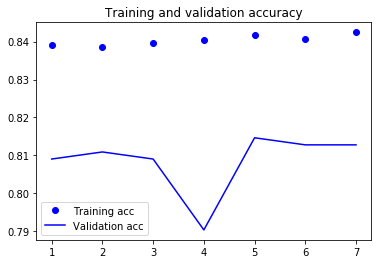

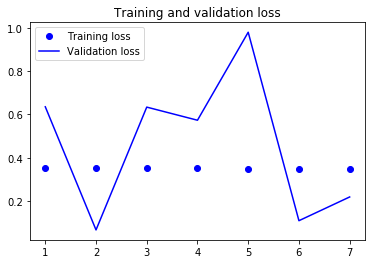

In [37]:
# Plot the results on Loss and Accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Inference -1

In [31]:
# Though training accuracy and Validation accuracy are in the range of 80%, the precision and recall scores are very low
# for training and validation cases
# This could be more to do with the imbalance of positive and negative cases in the training dataset(20-80 ratio)

In [32]:
# Option - Balance the dataset before training(40-60)

In [33]:
Pos_df = Images_sample_df[Images_sample_df['Target']==1]
Neg_df = Images_sample_df[Images_sample_df['Target']==0]

In [40]:
Neg_sample_df = Neg_df.sample(frac=0.5)

In [48]:
Images_corr_Sample_df = pd.concat([Pos_df,Neg_sample_df],axis=0)

In [62]:
train_test_dict(Images_corr_Sample_df,test_size=0.02,random_state=42)

In [65]:
# Run Fit Generator
history=model2.fit_generator(generator=train_generator,
                    epochs=2,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/2
817/817 [==============================] - 5131s 6s/step - loss: 0.3541 - acc: 0.8378 - f1_m: 0.5739 - precision_m: 0.6929 - recall_m: 0.5362 - val_loss: 0.0994 - val_acc: 0.8202 - val_f1_m: 0.1030 - val_precision_m: 0.1030 - val_recall_m: 0.1030
Epoch 2/2
817/817 [==============================] - 4795s 6s/step - loss: 0.3526 - acc: 0.8381 - f1_m: 0.5788 - precision_m: 0.6888 - recall_m: 0.5386 - val_loss: 0.2431 - val_acc: 0.8127 - val_f1_m: 0.1479 - val_precision_m: 0.1479 - val_recall_m: 0.1479


# Inference-2

In [66]:
#Even with slighly balanced data the precision and recall are not improving

In [69]:
# Retrain the last Batch

In [70]:
model_train_layers(model2,"conv5_block16_0_bn")

In [72]:
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

In [73]:
history=model2.fit_generator(generator=train_generator,
                    epochs=2,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/2
817/817 [==============================] - 5422s 7s/step - loss: 0.3517 - acc: 0.8372 - f1_m: 0.6155 - precision_m: 0.6487 - recall_m: 0.6216 - val_loss: 0.2017 - val_acc: 0.8034 - val_f1_m: 0.1629 - val_precision_m: 0.1629 - val_recall_m: 0.1629
Epoch 2/2
817/817 [==============================] - 4962s 6s/step - loss: 0.3519 - acc: 0.8383 - f1_m: 0.6201 - precision_m: 0.6525 - recall_m: 0.6288 - val_loss: 0.7948 - val_acc: 0.8034 - val_f1_m: 0.1629 - val_precision_m: 0.1629 - val_recall_m: 0.1629


# Conclusion

In [74]:
#With additional layer of training the validation precision and recall seems to be increasing.
# Training has to be done including additional layers with more epochs
